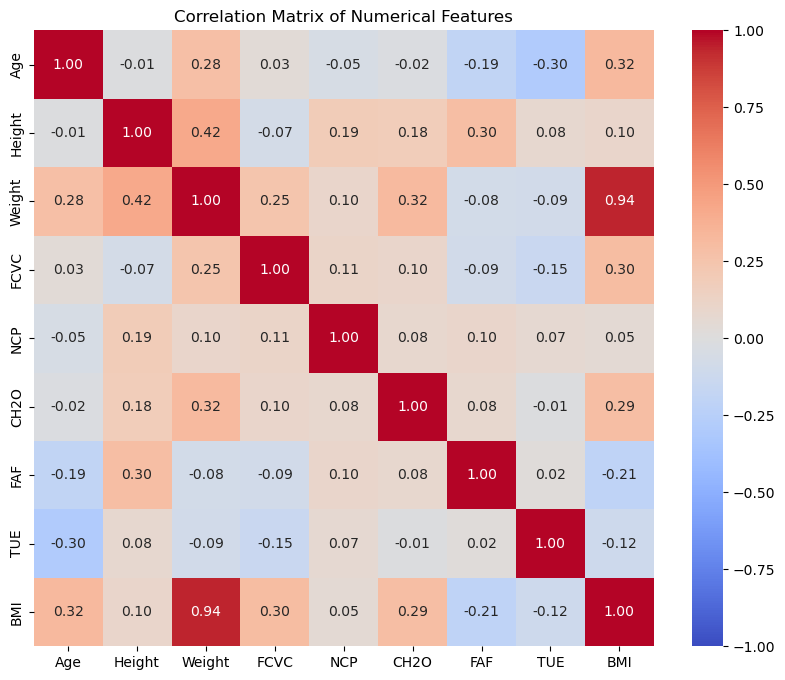

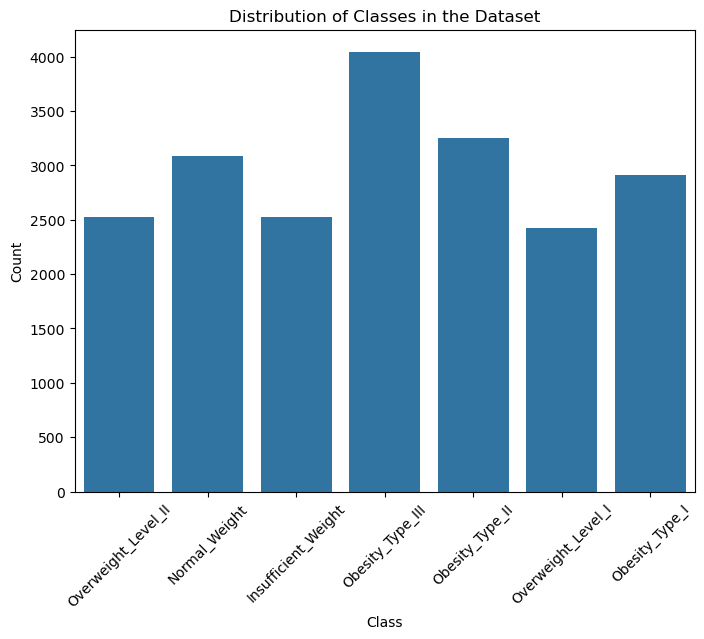

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\snady\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\snady\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.90      0.93      0.91       284
      Normal_Weight       0.89      0.88      0.88       513
     Obesity_Type_I       0.88      0.89      0.88       268
    Obesity_Type_II       0.99      0.98      0.98       425
   Obesity_Type_III       1.00      1.00      1.00       803
 Overweight_Level_I       0.75      0.78      0.76       261
Overweight_Level_II       0.83      0.80      0.82       285

           accuracy                           0.92      2839
          macro avg       0.89      0.89      0.89      2839
       weighted avg       0.92      0.92      0.92      2839



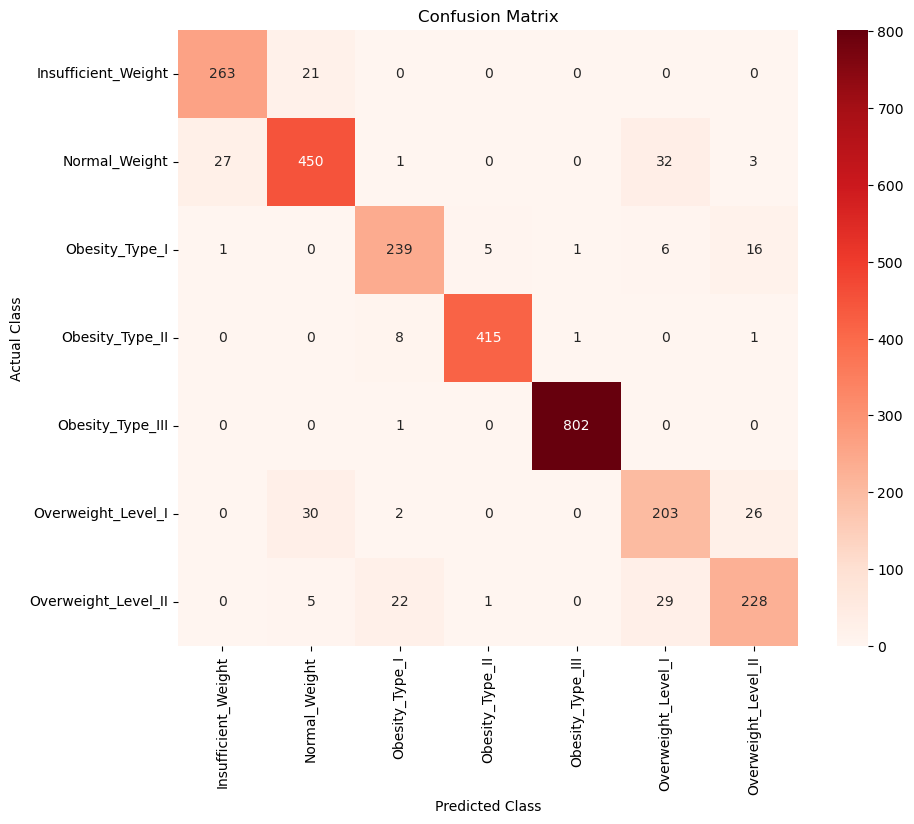

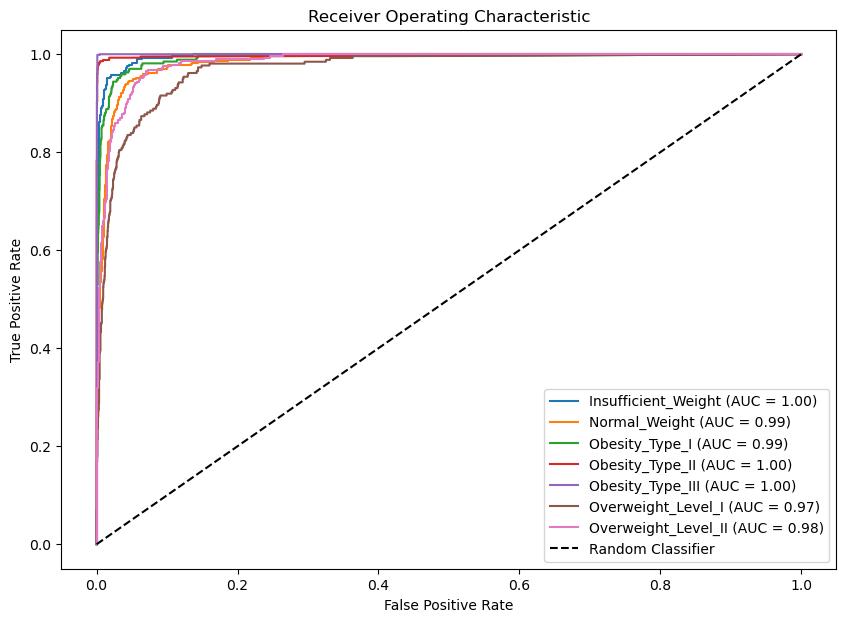

In [16]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Загрузка данных, исключая столбец 'id'
df = pd.read_csv(r'C:\Users\snady\.spyder-py3\train_obesity.csv', usecols=lambda column: column != 'id')
df['BMI'] = (df['Weight'] / pow(df['Height'], 2)).round(2)

def categorize(value):
    if value <= 16:
        return 'Very low'
    elif 16 < value <= 18.5:
        return 'Low'
    elif 18.5 < value <= 25:
        return 'Normal'
    elif 25 < value <= 30:
        return 'Above normal'
    elif 30 < value <= 35:
        return '1st class'
    elif 35 < value <= 40:
        return '2nd class'
    else:
        return '3rd class'

df['BMICategory'] = df['BMI'].map(categorize)
    
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']


# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вычисляем границы для выбросов на основе обучающих данных
def calculate_outlier_bounds(data, feature):
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

bounds = {feature: calculate_outlier_bounds(X_train, feature) for feature in numerical_features}

# Функция для удаления выбросов
def remove_outliers(data, bounds):
    outliers_index = []
    for feature, (lower, upper) in bounds.items():
        outliers_index.extend(data[(data[feature] < lower) | (data[feature] > upper)].index.tolist())
    return list(set(outliers_index))

# Удаляем выбросы из обучающих и тестовых данных
outliers_train = remove_outliers(X_train, bounds)
X_train_cleaned = X_train.drop(outliers_train).reset_index(drop=True)
y_train_cleaned = y_train.drop(outliers_train).reset_index(drop=True)

outliers_test = remove_outliers(X_test, bounds)
X_test_cleaned = X_test.drop(outliers_test).reset_index(drop=True)
y_test_cleaned = y_test.drop(outliers_test).reset_index(drop=True)


# Определение категориальных и числовых признаков
categorical_features = X_train_cleaned.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

correlation_matrix = X[numerical_features].corr()

# Визуализация корреляции через тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# 2. График распределения данных по классам
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title("Distribution of Classes in the Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Пайплайны предобработки
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# feature selection 
feature_selector = SelectKBest(score_func=f_classif, k=10) # топ 10 фичей

# Пайплайн 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),  # Добавлен этап отбора признаков
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Параметры для RandomizedSearchCV
param_dist = {
    'feature_selection__k': [5, 10, 15, 'all'],  # Перебор количества признаков
    'classifier__n_estimators': np.arange(100, 1000, 100),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_depth': np.arange(5, 20, 5),
    'classifier__min_samples_split': np.arange(2, 11, 2),
    'classifier__min_samples_leaf': np.arange(1, 6, 1),
    'classifier__criterion': ['gini', 'entropy']
}


# RandomizedSearchCV 
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,  
    cv=5,      
    random_state=42,
    n_jobs=-1,  
    verbose=1
)

# Обучение модели с подбором параметров
random_search.fit(X_train_cleaned, y_train_cleaned)

# Лучшая модель
best_pipeline = random_search.best_estimator_

# Прогнозирование на тестовых данных
y_pred = best_pipeline.predict(X_test_cleaned)

# Оценка модели
report = classification_report(y_test_cleaned, y_pred)
print("Classification Report:\n", report)

# Матрица ошибок
cm = confusion_matrix(y_test_cleaned, y_pred)
cm_df = pd.DataFrame(cm, index=best_pipeline.classes_, columns=best_pipeline.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Добавляем ROC-кривую для оценки
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Преобразуем метки в бинарный формат
y_test_bin = label_binarize(y_test_cleaned, classes=best_pipeline.classes_)
y_pred_prob = best_pipeline.predict_proba(X_test_cleaned)

# Строим ROC-кривую для каждого класса
plt.figure(figsize=(10, 7))
for i in range(len(best_pipeline.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{best_pipeline.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
